Alright Try number 2! This time we use tensorflow as well, along with the following tricks:
* Experience Replay 
* Fixed Q-targets 

In [1]:
# For DQN
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math

# For Experience Replay
from collections import deque
import random

#For Display (illustrator())
from matplotlib import pyplot as plt
import pygame
from pygame.locals import *

#For Testing
from time import time

signature = 'DQN '

pygame 2.0.1 (SDL 2.0.14, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
class board:
    
    def __init__(self):    
        #Game specific Variables
        self.turn = 1
        self.moves_left = 9
        self.state = np.array([[0 for _ in range(9)]])
        self.mask = np.array([[1 for _ in range(9)]])
        
    def update(self, action):
        
        if self.state[0][action] != 0:
            raise ValueError('invalid move!', self.state, self.turn, self.moves_left, action)
            return 'invalid move'
            
        self.state[0][action] = self.turn
        self.mask[0][action] = 0
        self.turn = (self.turn == 1)*(-1)+(self.turn == -1)*(1)
        self.moves_left -= 1
        
        if self.moves_left < 5:
            win_cond = -3*self.turn
                        
            # row check
            temp = action//3 * 3
            if self.state[0][temp] + self.state[0][temp+1] + self.state[0][temp+2] == win_cond:
                return f"{-1*self.turn} won"
            
            # col check
            if self.state[0][action] + self.state[0][(action+3)%9] + self.state[0][(action+6)%9] == win_cond:
                return f"{-1*self.turn} won"
            
            #diag check
            if action%2 == 0:
                if self.state[0][0] + self.state[0][4] + self.state[0][8] == win_cond \
                or self.state[0][2] + self.state[0][4] + self.state[0][6] == win_cond:
                    return f"{-1*self.turn} won"
                            
            if self.moves_left == 0:
                return 'tie'
        
        return 'valid move'

    def reset(self):
        self.turn = 1
        self.moves_left = 9
        self.state = np.array([[0 for _ in range(9)]])
        self.mask = np.array([[1 for _ in range(9)]])

class game:
    
    def __init__(self):
        #RL Variables
        self.terminal = False
        self.reward = 0
        
        #Tic Tac Toe Board
        self.gameboard = board()
        
    def update(self, action):                    
        result = self.gameboard.update(action)
        
        if result == 'invalid move':
            self.reward = -1
            self.terminal = True
            
        elif result == 'valid move':
            self.reward = 0
            self.terminal = False
            
        elif result == '1 won':
            self.reward = 1 * -1 * self.gameboard.turn
            self.terminal = True
            
        elif result == '-1 won':
            self.reward = -1 * -1 * self.gameboard.turn
            self.terminal = True
        
        elif result == 'tie':
            self.reward = 0
            self.terminal = True
                
    def reset(self):
        self.gameboard.reset()
        
        self.terminal = False
        self.reward = 0
    
    def return_state_features(self):
        return self.gameboard.state.reshape(1,9)*self.gameboard.turn
    
    def get_mask(self):
        return self.gameboard.mask
    
    def get_reward(self):
        return self.reward
    
class illustrator:
    
    def __init__(self, host_game):
        self.host = host_game
    
    def draw(self, state=None):
        if state is not None:
            st = state
        else:
            st = self.host.gameboard.state*self.host.gameboard.turn
        
        def convert(n):
            return "X"*(n==1) + " "*(n==0) + "O"*(n==-1)
        temp = [[convert(int(st[0][3*j+i])) for i in range(3)] for j in range(3)]
        
        print(f"{temp[0][0]}|{temp[0][1]}|{temp[0][2]}")
        print("-----")
        print(f"{temp[1][0]}|{temp[1][1]}|{temp[1][2]}")
        print("-----")
        print(f"{temp[2][0]}|{temp[2][1]}|{temp[2][2]}")

In [3]:
class player:
    def __init__(self):
        self.epsilon = 0
        
    def q_values(self, s):
        return "IS A PLAYER"
    
    def choose_action(self, s, m):
        return int(input("Where would you like to move? "))

Features:
* replay memory 
* freeze net 
* UCB 
* advantage stream? 
* mcts?

In [4]:
class memory_replay:
    
    def __init__(self, max_size):
        
        self.max = max_size 
        self.mem = deque()
    
    def add(self, info_list):
        
        if len(self.mem) < self.max:
            self.mem.append(info_list)
            
        else:
            self.mem.popleft()
            self.mem.append(info_list)
            
    def sample(self, mb_size):
        
        sample_size = min(mb_size, len(self.mem))
        training_set = random.sample(self.mem, sample_size)
        return training_set

In [5]:
class dqn:
    def __init__(self, inp_features, num_actions, epsilon, gamma, decay=0.99999, unfreeze_freq=5000, mem_size=5000, \
                optimizer = keras.optimizers.SGD(learning_rate=0.0009, momentum=0.00007, name="SGD"), loss = keras.losses.MSE):
        
        #Make the trainable variables
        self.epsilon = epsilon
        self.gamma = gamma
        self.decay = decay
        self.min_epsilon = 0.1
        
        self.loss = loss
        self.optimizer = optimizer #alpha should be included in the optimizer
        
        self.num_actions = num_actions
        self.u_freq = unfreeze_freq
        self.counter = unfreeze_freq
        self.memory = memory_replay(mem_size)
        self.gradient_update = []
        
        # Make the network
        inputs = keras.Input(shape=(inp_features,), name="inp")
        x = layers.Dense((inp_features*5//4), activation="relu", name="layer_1")(inputs)
        x = layers.Dense((inp_features*10//9), activation="relu", name="layer_2")(x)
        outputs = layers.Dense(num_actions, activation="tanh", name="q_values")(x)
        self.q_net = keras.Model(inputs=inputs, outputs=outputs)
        self.freeze_net = tf.keras.models.clone_model(self.q_net)
        self.freeze_net.set_weights(self.q_net.get_weights())
    
        def update(q_true, s, mask):
            with tf.GradientTape() as tape:
                pred = self.q_values(s)*mask
                loss = self.loss(q_true, pred)
                loss += sum(self.q_net.losses)

            gradient = tape.gradient(loss, self.q_net.trainable_weights)
            self.optimizer.apply_gradients(zip(gradient, self.q_net.trainable_weights))
            return gradient
            
        inps = (tf.TensorSpec(shape=[None, self.num_actions],dtype=tf.float32), \
                tf.TensorSpec(shape=[None, inp_features],dtype=tf.float32), \
                tf.TensorSpec(shape=[None, self.num_actions], dtype=tf.float32))
        self.update = tf.function(func= update, input_signature= inps)
        

        def q_values(state_features):
            return self.q_net(state_features)

        self.q_values = tf.function(func= q_values, input_signature=(tf.TensorSpec(shape=[None, inp_features],dtype=tf.float32),))

        def q_freeze(state_features):
            return self.freeze_net(state_features)
        
        self.q_freeze = tf.function(func= q_freeze, input_signature=(tf.TensorSpec(shape=[None, inp_features],dtype=tf.float32),))
        
    def choose_action(self, state_features, mask = None):
        
        if self.epsilon > self.min_epsilon:
            self.epsilon*=self.decay
        
        if np.random.rand() < self.epsilon:
            p = np.random.uniform(size=(1,self.num_actions))
            if mask is not None: p*= mask
            return int(p.argmax())
        
        q_values = self.q_values(state_features)
        q_values = (q_values + 1)
        if mask is not None: q_values*=mask
        return int(tf.argmax(q_values[0]))
        
    def update_normal(self, s, a, r, s2, a2=None, mb_size = 64):
        
        self.memory.add([False, s,a,r,s2,a2])
        self.train_step(mb_size)
        
    def update_final(self, s, a, r, mb_size = 64):
                
        self.memory.add([True, s,a,r])
        self.train_step(mb_size)
        
    def train_step(self, mb_size): 

        if self.counter >=1:
            self.counter -=1
        else:
            self.counter = self.u_freq
            self.freeze_net.set_weights(self.q_net.get_weights())
        
        data = self.memory.sample(mb_size)
        
        states = []
        rewards, mask = [np.zeros((len(data), self.num_actions)) for i in range(2)]
        
        for i, step in enumerate(data):
            if step[0]:
                s,a,r = step[1:]
            else:
                s,a,r,s2,a2 = step[1:]
                r+= self.gamma*tf.reduce_max(self.q_freeze(s2)).numpy()
                
            rewards[i, a] = r
            mask[i, a] = 1
            states.append(s.reshape(-1))
            
        q_true = tf.constant(rewards, dtype=tf.float32)
        s = tf.constant(states, dtype=tf.float32)
        mask = tf.constant(mask, dtype=tf.float32)
        grad = self.update(q_true, s, mask)
        
        total_update = 0
        for g in grad:
            total_update += tf.reduce_sum(tf.abs(g))
        self.gradient_update.append(total_update)
        
    def reset_gradient_update(self):
        size = sum(self.gradient_update)
        self.gradient_update = []
        return size
        
    def save(self, filename='sample', adjust = True):
        if adjust: filename = signature + filename
        self.q_net.save(filename)
    
    def load(self, filename='sample', adjust = True):
        if adjust: filename = signature + filename
        self.q_net = keras.models.load_model(filename)
        self.freeze_net = keras.models.load_model(filename)
        

In [23]:
SAMPLEMEM = agent.memory.mem 

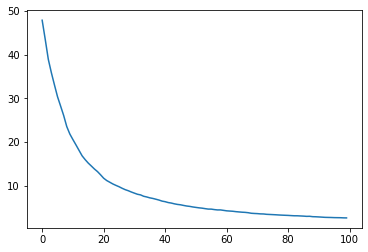

In [27]:
agent = dqn(9, 9, 1, 0.8, decay=decay, optimizer=keras.optimizers.SGD(learning_rate=0.00012, momentum=0.00003, name="SGD"))
agent.memory.mem = SAMPLEMEM
n = []
for i in range(100):
    agent.train_step(100)
    n.append(agent.reset_gradient_update())
    
x = np.arange(0,len(n))
y = np.array(n)
plt.plot(x,y)

In [58]:
start = time()

training_eps, expec_steps = 50000, 9
#steps_list = []
grads_list = []
decay = (0.1)**(1/(training_eps*expec_steps)) #min_epsilon = 0.1

b = game()
agent = dqn(9, 9, 1, 0.8, decay=decay, optimizer=keras.optimizers.SGD(learning_rate=0.00082, momentum=0.0001, name="SGD"))
mb_size = 32

for ep in range(1, training_eps+1):
            
    s1, m1 = b.return_state_features(), b.get_mask()
    a1 = agent.choose_action(s1, m1) 
    b.update(a1)
    r1 = b.get_reward()
    
    s2, m2 = b.return_state_features(), b.get_mask()
    a2 = agent.choose_action(s2, m2) 
    b.update(a2)
    r2 = b.get_reward()
     
    remember = [(s2, a2, r2), (s1, a1, r1)]
    steps = 1

    while not b.terminal:

        s, m = b.return_state_features(), b.get_mask()
        a = agent.choose_action(s,m)
        b.update(a)
        r = b.get_reward()

        sb, ab, rb = remember.pop()
        remember.insert(0, (s,a,r))
        agent.update_normal(sb, ab, rb, s, a, mb_size = mb_size)
        
        steps+=1

    sb, ab, rb = remember.pop()
    sg, ag, rg = remember.pop()
    agent.update_final(sg, ag, rg, mb_size = mb_size)
    agent.update_final(sb, ab, rg*(-1), mb_size = mb_size)
    
    b.reset()
    #steps_list.append(steps)
    grads_list.append(agent.reset_gradient_update()/(mb_size*steps))
    
    print(f"{ep} eps are done! Agent epsilon: {agent.epsilon}. Took {steps} steps with update of {grads_list[-1]}   ", end='\r')

print("\n")
agent.save('agent_{} simple DQN'.format(training_eps))
print("\nDone!")

time() - start

50000 eps are done! Agent epsilon: 0.16306221347847136. Took 7 steps with update of 0.7342290282249451    

INFO:tensorflow:Assets written to: DQN agent_50000 simple DQN\assets

Done!


7256.7591190338135

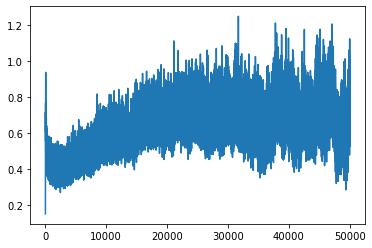

In [59]:
x = np.arange(0,len(grads_list))
y = np.array(grads_list)
plt.plot(x,y)

In [32]:
m = np.array([[1, 0,0,1,1,0,1,1,1]])
p = np.random.uniform(size=(1,9))
print("Before p: ", p)
print("Mask m:", m)
print(p.shape)
print(m.shape)
if m is not None: p= p*m
print("After p: ", p)

Before p:  [[0.35165957 0.03228974 0.09829543 0.22855671 0.37016127 0.72718488
  0.70028248 0.1628494  0.82952456]]
Mask m: [[1 0 0 1 1 0 1 1 1]]
(1, 9)
(1, 9)
After p:  [[0.35165957 0.         0.         0.22855671 0.37016127 0.
  0.70028248 0.1628494  0.82952456]]


In [60]:
b = game()
i = illustrator(b)
player1 = agent#player()
player2 = agent#agent#player()

init_e1, init_e2 = player1.epsilon, player2.epsilon
player1.epsilon, player2.epsilon = 0, 0

while not b.terminal:
    s, m = b.return_state_features(), b.get_mask()
    print(f"player1 thinks values are {player1.q_values(s)}")
    i.draw()
    a = player1.choose_action(s, m)
    b.update(a)
    r = b.get_reward()
    print(f"action was {a} and the reward was {r}\n")
    

    if not b.terminal:
        s, m = b.return_state_features(), b.get_mask()
        print(f"player2 thinks values are {player2.q_values(s)}")
        i.draw()
        a = player2.choose_action(s, m)
        b.update(a)
        r = b.get_reward()
        print(f"action was {a} and the reward was {r}\n")
            
player1.epsilon, player2.epsilon = init_e1, init_e2
i.draw()

player1 thinks values are [[0.46258163 0.43423808 0.62625605 0.34981054 0.41913798 0.5427545
  0.42885187 0.4315722  0.63846767]]
 | | 
-----
 | | 
-----
 | | 
action was 8 and the reward was 0

player2 thinks values are [[ 0.07513438 -0.12841648  0.12475929 -0.28915334 -0.20171447 -0.25552863
  -0.09003791 -0.13722306  0.07410436]]
 | | 
-----
 | | 
-----
 | |O
action was 2 and the reward was 0

player1 thinks values are [[0.53842163 0.5373466  0.7355229  0.26582757 0.5877971  0.6789705
  0.7619905  0.54149413 0.80001795]]
 | |O
-----
 | | 
-----
 | |X
action was 6 and the reward was 0

player2 thinks values are [[-0.45817205 -0.70889145 -0.58439106 -0.7680274  -0.307859   -0.9031472
  -0.48623288  0.313179   -0.00679248]]
 | |X
-----
 | | 
-----
O| |O
action was 7 and the reward was 0

player1 thinks values are [[0.49281827 0.5498089  0.68957835 0.35950446 0.5691828  0.44700146
  0.6965835  0.42797977 0.63471144]]
 | |O
-----
 | | 
-----
X|O|X
action was 4 and the reward was 0

playe

In [8]:
b = game()
i = illustrator(b)
agent = dqn(9, 9, 1, 0.8, decay=0.99, optimizer=keras.optimizers.SGD(learning_rate=0.0009, momentum=0.00007, name="SGD"))


s1, m1 = b.return_state_features(), b.get_mask()
print(f"player1 thinks values are {agent.q_values(s1)}")
print(f"mask is {m1}")
i.draw()
a1 = agent.choose_action(s1, m1) 
b.update(a1)
r1 = b.get_reward()
print(f"action was {a1} and the reward was {r1}\n")

s2, m2 = b.return_state_features(), b.get_mask()
print(f"player1 thinks values are {agent.q_values(s2)}")
print(f"mask is {m2}")
i.draw()
a2 = agent.choose_action(s2, m2) 
b.update(a2)
r2 = b.get_reward()
print(f"action was {a2} and the reward was {r2}\n")

remember = [(s2, a2, r2), (s1, a1, r1)]
steps = 1

while not b.terminal:

    s, m = b.return_state_features(), b.get_mask()
    print(f"player1 thinks values are {agent.q_values(s)}")
    print(f"mask is {m}")
    i.draw()
    a = agent.choose_action(s, m)
    b.update(a)
    r = b.get_reward()
    print(f"action was {a} and the reward was {r}\n")

    sb, ab, rb = remember.pop()
    remember.insert(0, (s,a,r))
    agent.update_normal(sb, ab, rb, s, a, mb_size = 20)

    steps+=1
    print('yay')

sb, ab, rb = remember.pop()
sg, ag, rg = remember.pop()
agent.update_final(sg, ag, rg, mb_size = 20)
agent.update_final(sb, ab, rg*(-1), mb_size = 20)

i.draw()
b.reset()

player1 thinks values are [[0. 0. 0. 0. 0. 0. 0. 0. 0.]]
mask is [[1 1 1 1 1 1 1 1 1]]
 | | 
-----
 | | 
-----
 | | 
action was 1 and the reward was 0

player1 thinks values are [[-0.40544295  0.51106715 -0.21474798 -0.17592032  0.04194491 -0.10426518
   0.07508005  0.1880093   0.04645349]]
mask is [[1 0 1 1 1 1 1 1 1]]
 |O| 
-----
 | | 
-----
 | | 
action was 6 and the reward was 0

player1 thinks values are [[-0.2801775   0.04971854  0.30935258 -0.08465388  0.17671342  0.20639361
   0.2816697  -0.31822774 -0.25919774]]
mask is [[1 0 1 1 1 1 0 1 1]]
 |X| 
-----
 | | 
-----
O| | 
action was 4 and the reward was 0

yay
player1 thinks values are [[-0.60675293  0.6063926  -0.33959913 -0.31059304 -0.31372195 -0.04563268
   0.00279822  0.13560483 -0.08742871]]
mask is [[1 0 1 1 0 1 0 1 1]]
 |O| 
-----
 |O| 
-----
X| | 
action was 7 and the reward was 0

yay
player1 thinks values are [[-0.08063656  0.4866256  -0.24605937 -0.00481645  0.10860009  0.17790893
   0.3923865  -0.48966163 -0.136830

In [49]:
class sarsa_simple:
    def __init__(self, num_states, num_actions, alpha, epsilon, gamma, decay=0.99999):
        self.q_table = np.zeros((num_states, num_actions))
        self.alpha = alpha
        self.epsilon = epsilon
        self.min_epsilon = 0.1
        self.decay = decay
        self.gamma = gamma
        
    def pre_process(state_features):
        st = 0
        for i in range(9):
            st+= 3**i * (state_features[0][i]+1)
        return st
    
    def q_values(self, state_features):
        return self.q_table[sarsa_simple.pre_process(state_features)]
        
    def choose_action(self, state_features, mask):
        
        if self.epsilon > self.min_epsilon:
            self.epsilon*=self.decay
        
        if np.random.rand() < self.epsilon:
            p = np.random.uniform(size=(1,9)) * mask
            return int(p.argmax())
        
        q_values = self.q_values(state_features)
        q_values = (q_values + 1) * mask
        
        return int(q_values.argmax())
        
    def update_normal(self, s, a, r, s2, a2):
        s = sarsa_simple.pre_process(s)
        s2 = sarsa_simple.pre_process(s2)
        self.q_table[s][a] += self.alpha*(r+self.gamma*self.q_table[s2][a2]-self.q_table[s][a])
    
    def update_final(self, s, a, r):
        s = sarsa_simple.pre_process(s)
        self.q_table[s][a] += self.alpha*(r-self.q_table[s][a])

import json 

def save_simple(agent, filename = 'simple_agent'):
    
    data = {"q_table": agent.q_table.tolist(),
            "gamma": agent.gamma,
            "alpha": agent.alpha,
            "epsilon": agent.epsilon,
            "decay": agent.decay}
    
    with open(filename, "w") as f:
        json.dump(data, f)

def load_simple(filename = 'simple_agent'):
    
    with open(filename, "r") as f:
        data = json.load(f)
    
    agent = sarsa_simple(1,1,0,0,0)
    
    agent.q_table = np.array(data["q_table"])
    agent.alpha = data['alpha']
    agent.gamma = data['gamma']
    agent.epsilon = data['epsilon']
    agent.decay = data['decay']
    return agent

In [70]:
b = game()
i = illustrator(b)

player2 = agent
player1 = load_simple('agent_300000')

init_e1, init_e2 = player1.epsilon, player2.epsilon
expl_rate = 0.1
player1.epsilon, player2.epsilon = expl_rate, expl_rate 

num_matches = 5000
p1_wins = 0
p2_wins = 0
for i in range(1, num_matches+1):
    
    while not b.terminal:
        s, m = b.return_state_features(), b.get_mask()
        a = player1.choose_action(s, m)
        b.update(a)
        r = b.get_reward()
        if r == 1:
            p1_wins +=1


        if not b.terminal:
            s, m = b.return_state_features(), b.get_mask()
            a = player2.choose_action(s, m)
            b.update(a)
            r = b.get_reward()
            if r == 1:
                p2_wins+=1
                    
    b.reset()
    
    if i%100==0:
        msg1 = f'player 1 {str(player1.__class__)[17:-2]} won {p1_wins} times'
        msg2 = f' and player 2 {str(player2.__class__)[17:-2]} won {p2_wins} times.' 
        msg3 = f' They drew {i-p1_wins-p2_wins} times.'
        msg4 = f' They played {i} games.    '
        print(msg1 + msg2 + msg3 + msg4 + '        ', end = '\r')
    #print(f"hi {i}", end='\r') 
player1.epsilon, player2.epsilon = init_e1, init_e2

In [69]:
b = game()
i = illustrator(b)
player1 = agent#player()
player2 = load_simple('agent_300000')

init_e1, init_e2 = player1.epsilon, player2.epsilon
player1.epsilon, player2.epsilon = 0, 0

while not b.terminal:
    s, m = b.return_state_features(), b.get_mask()
    print(f"player1 thinks values are {player1.q_values(s)}")
    i.draw()
    a = player1.choose_action(s, m)
    b.update(a)
    r = b.get_reward()
    print(f"action was {a} and the reward was {r}\n")
    

    if not b.terminal:
        s, m = b.return_state_features(), b.get_mask()
        print(f"player2 thinks values are {player2.q_values(s)}")
        i.draw()
        a = player2.choose_action(s, m)
        b.update(a)
        r = b.get_reward()
        print(f"action was {a} and the reward was {r}\n")
            
player1.epsilon, player2.epsilon = init_e1, init_e2
i.draw()

player1 thinks values are [ 0.04448604  0.00903321  0.04734044  0.05046598  0.14577523 -0.00539944
  0.03828195  0.06640134  0.04881157]
 | | 
-----
 | | 
-----
 | | 
action was 4 and the reward was 0

player2 thinks values are [[-0.06754432  0.02131769  0.12639712  0.08479375 -0.43347448  0.110697
  -0.15785258  0.0199419   0.06101904]]
 | | 
-----
 |O| 
-----
 | | 
action was 2 and the reward was 0

player1 thinks values are [ 0.05933756  0.21819092  0.         -0.01220219  0.          0.03981587
  0.06206419 -0.01840248  0.03726664]
 | |O
-----
 |X| 
-----
 | | 
action was 1 and the reward was 0

player2 thinks values are [[-0.05973139  0.13117014  0.18427747  0.26295444 -0.37683424  0.21481459
  -0.10802469  0.19284865  0.13578682]]
 |O|X
-----
 |O| 
-----
 | | 
action was 3 and the reward was 0

player1 thinks values are [0.6219639  0.         0.         0.         0.         0.24250834
 0.21694198 1.         0.64099798]
 |X|O
-----
O|X| 
-----
 | | 
action was 7 and the reward wa